In [0]:
import numpy as np
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
import time

import matplotlib.pyplot  as plt
%matplotlib inline

# Part A
## Model Design
- Use Gaussian {encoder, prior, decoder } with 3 different latent space sizes of
{1,2,16 }. Use the typical linear layers used in pytorch models https://github.com/pytorch/examples/tree/master/vae. Use Learing rate of 0.001. Dont go
more than 30 Epochs

## Deliverables
- Visualise the latent space for latent dimension of 1 and 2 for the posterior.
- Generate 500 samples from posterior and 500 from the prior for latent dimension
of 1 and visualise them together in a diagram. Do they match each other?
- Generate 128 samples from the prior and decode them. How different are samples
from models with different latent size? How different the decoded samples are
when you traverse through prior space?

In [0]:
batch_size = 100
learning_rate = 0.001
latent_spaces = [1,2,16]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
trainset = datasets.MNIST('train_data', download=True, train=True, transform=transforms.Compose([transforms.ToTensor()]))
testset = datasets.MNIST('test_data', download=True, train=False, transform=transforms.Compose([transforms.ToTensor()]))
plot_data = trainset.data[:500]

0it [00:00, ?it/s]

9920512it [00:01, 9592835.44it/s]                            


Extracting train_data/MNIST/raw/train-images-idx3-ubyte.gz to train_data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 140979.51it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting train_data/MNIST/raw/train-labels-idx1-ubyte.gz to train_data/MNIST/raw


1654784it [00:00, 2307065.17it/s]                            
0it [00:00, ?it/s]

Extracting train_data/MNIST/raw/t10k-images-idx3-ubyte.gz to train_data/MNIST/raw


8192it [00:00, 35254.68it/s]            
0it [00:00, ?it/s]

Extracting train_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to train_data/MNIST/raw
Processing...
Done!


9920512it [00:01, 9194674.24it/s]                            


Extracting test_data/MNIST/raw/train-images-idx3-ubyte.gz to test_data/MNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 104544.38it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting test_data/MNIST/raw/train-labels-idx1-ubyte.gz to test_data/MNIST/raw


1654784it [00:00, 2305954.52it/s]                            
0it [00:00, ?it/s]

Extracting test_data/MNIST/raw/t10k-images-idx3-ubyte.gz to test_data/MNIST/raw


8192it [00:00, 53780.79it/s]            


Extracting test_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to test_data/MNIST/raw
Processing...
Done!


In [0]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

In [0]:
dataiter = iter(train_loader)
images, _ = dataiter.next()
images.shape

torch.Size([100, 1, 28, 28])

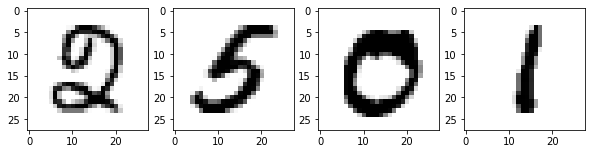

In [0]:
fig = plt.figure(figsize=(10, 10))
def show_image(i, image): 
  # image = image.reshape(1, 28, 28)
  fig.add_subplot(1, 4, i+1)
  plt.imshow(image.numpy().squeeze(), cmap='gray_r')
  

for i in range(0, 4):
  show_image(i, images[i])
plt.show()

In [0]:
# https://github.com/pytorch/examples/blob/master/vae/main.py
class VAE(nn.Module):
  def __init__(self, latent_size=1):
    super(VAE, self).__init__()

    self.fc1 = nn.Linear(784, 400)
    self.fc21 = nn.Linear(400, latent_size)
    self.fc22 = nn.Linear(400, latent_size)
    self.fc31 = nn.Linear(latent_size, 400)
    self.fc32 = nn.Linear(latent_size, 400)    
    self.fc4 = nn.Linear(400, 784)


  def encode(self, x):
    h1 = F.relu(self.fc1(x))
    return self.fc21(h1), self.fc22(h1)

  @staticmethod
  def reparameterize(mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return mu + eps*std

  def decode(self, z):
    h31 = F.relu(self.fc31(z))
    h32 = F.relu(self.fc32(z))
    return self.fc4(h31), self.fc4(h32)

  def sample(self, z):
    de_mu, de_log_var = self.decode(z)
    full_generation_path = self.reparameterize(de_mu, de_log_var)
    without_decoder_noise = de_mu
    return full_generation_path, without_decoder_noise

  def forward(self, x):
    en_mu, en_log_var = self.encode(x.view(-1, 784))
    z = self.reparameterize(en_mu, en_log_var)
    de_mu, de_log_var = self.decode(z)
    deconstruction = self.reparameterize(de_mu, de_log_var)
    return en_mu, en_log_var, z, de_mu, de_log_var, deconstruction
  
  @staticmethod
  def loss(x, en_mu, en_log_var, de_mu, de_log_var):
    # print("mu:", en_mu, "\ņ log_var", en_log_var, "\n de_mu", de_mu, "\n de_loga_var", de_log_var)
    decoder_std = torch.exp(0.5 * de_log_var)
    reconstruction_loss = torch.mean(- (Normal(de_mu, decoder_std).log_prob(x.view(-1, 784))) ) / np.log(2)

    kl_loss = torch.mean(-0.5 * torch.sum(1 + en_log_var - en_mu.pow(2) - en_log_var.exp(), dim=-1))
    # print("kl:", torch.mean(kl_loss), "recon_loss:", reconstruction_loss)
    ELBO = reconstruction_loss + kl_loss
    return ELBO, kl_loss, reconstruction_loss

In [0]:
def train_vae(vae, epochs=6):
  optimizer = torch.optim.Adam(vae.parameters(),lr=learning_rate)

  EPOCH = epochs
  train_loss = []
  train_kld = []
  train_nll = []

  val_loss = []
  val_kld = []
  val_nll = []

  for epoch in range(EPOCH):
    vae.train()
    start_time = time.time()
    for i, x in enumerate(train_loader, 0):
      x, _ = x
      x = x.to(device).float()
    
      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      mu, log_var, _, de_mu, de_log_var, _ = vae(x)

      loss, kld, nll = vae.loss(x, mu, log_var, de_mu, de_log_var)

      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())
      train_kld.append(kld.item())
      train_nll.append(nll.item())
    # print statistics
    with torch.set_grad_enabled(False):
      for val_batch in test_loader:
        x_val, _ = val_batch
        x_val = x_val.to(device).float()
        mu, log_var, _, de_mu, de_log_var, _ =  vae(x_val)
        v_loss, v_kld, v_nll = vae.loss(x_val, mu, log_var, de_mu, de_log_var)

        val_loss.append(v_loss.item())
        val_kld.append(v_kld.item())
        val_nll.append(v_nll.item())
      sec = (time.time() - start_time)
    if (epoch % 5 == 0):
      print("--- epoch:", epoch, "sec:", sec, "---")
      print("loss:", loss.item(), "val loss:", v_loss.item(), 
            "KLD:", kld.item(), "val KLD:", v_kld.item(), "\n")
  return train_loss, train_kld, train_nll, val_loss, val_kld, val_nll

In [0]:
def plot_loss(train_loss, train_kld, train_nll, val_loss, val_kld, val_nll): 
  f, axarr = plt.subplots(1,3, figsize=(15,5))

  ax = axarr[0]
  ax.set_title('ELBO')
  ax.plot(train_loss, label = "ELBO_train_loss")
  ax.plot(np.arange(0, len(train_loss),(len(train_loss)/len(val_loss))), val_loss, label = "ELBO_val_loss")

  ax = axarr[1]
  ax.set_title('KL')
  ax.plot(train_kld, label = "kld_train_loss")
  ax.plot(np.arange(0, len(train_kld),(len(train_kld)/len(val_kld))), val_kld, label = "KL_val_loss")

  ax = axarr[2]
  ax.set_title('NLL')
  ax.plot(train_nll, label = "NLL_train_loss")
  ax.plot(np.arange(0, len(train_nll),(len(train_nll)/len(val_nll))), val_nll, label = "NLL_val_loss")
  plt.show()

In [0]:
from sklearn.manifold import TSNE
def plot_samples(vae, plot_data, latent_space):
  f, axarr = plt.subplots(2,2, figsize=(15,10))
  vae.eval()
  z = torch.randn(500, latent_space).to(device)
  full_generation_path, without_decoder_noise = vae.sample(z)
  full_generation_path = full_generation_path.cpu().data.numpy().reshape(-1,28,28) 
  without_decoder_noise = without_decoder_noise.cpu().data.numpy().reshape(-1,28,28)
  mu, log_var, z, x_mu, x_log_var, deconstruction = vae(plot_data.to(device).float())

  latent_space_z = z.cpu().data.numpy()

  if latent_space == 1:
    ax = axarr[0][0]
    ax.set_title('latent space')
    ax.scatter(latent_space_z, np.zeros(latent_space_z.shape))
    ax.axis('equal')
  elif latent_space == 2:
    ax = axarr[0][0]
    ax.set_title('latent space')
    ax.scatter(latent_space_z[:,0], latent_space_z[:,1])
    ax.axis('equal')
  else:
    z_embedded = TSNE(n_components=2).fit_transform(latent_space_z)
    ax = axarr[0][0]
    ax.set_title('latent space')
    ax.scatter(z_embedded[:,0], z_embedded[:,1])
    ax.axis('equal')

 
  decon_image = deconstruction[0].cpu().data.numpy().reshape(28,28)
  ax = axarr[0][1]
  ax.set_title('1 Reconstruced samples')
  ax.imshow(decon_image, cmap='gray_r')
  ax.axis('equal')

  
  
  ax = axarr[1][0]
  ax.set_title('full_generation_path')
  ax.imshow(full_generation_path[0], cmap='gray_r')
  ax.axis('equal')

  ax = axarr[1][1]
  ax.set_title('without_decoder_noise')
  ax.imshow(without_decoder_noise[0], cmap='gray_r')
  ax.axis('equal')

  plt.show()

--- epoch: 0 sec: 7.682785272598267 ---
loss: -1.4334203004837036 val loss: -1.4216148853302002 KLD: 0.0078608812764287 val KLD: 0.00952195655554533 

--- epoch: 5 sec: 7.4473865032196045 ---
loss: -1.6244678497314453 val loss: -1.5367928743362427 KLD: 0.01491426583379507 val KLD: 0.013483475893735886 

--- epoch: 10 sec: 7.5346198081970215 ---
loss: -1.618620753288269 val loss: -1.4304540157318115 KLD: 0.02535363659262657 val KLD: 0.030407017096877098 

--- epoch: 15 sec: 7.513950824737549 ---
loss: -1.6382777690887451 val loss: -1.6162192821502686 KLD: 0.013244075700640678 val KLD: 0.03203994035720825 

--- epoch: 20 sec: 7.566748380661011 ---
loss: -1.4315574169158936 val loss: -1.4359604120254517 KLD: 0.01990690268576145 val KLD: 0.01851026527583599 

--- epoch: 25 sec: 7.545917272567749 ---
loss: -1.521217942237854 val loss: -1.5643893480300903 KLD: 0.015339836478233337 val KLD: 0.013436958193778992 



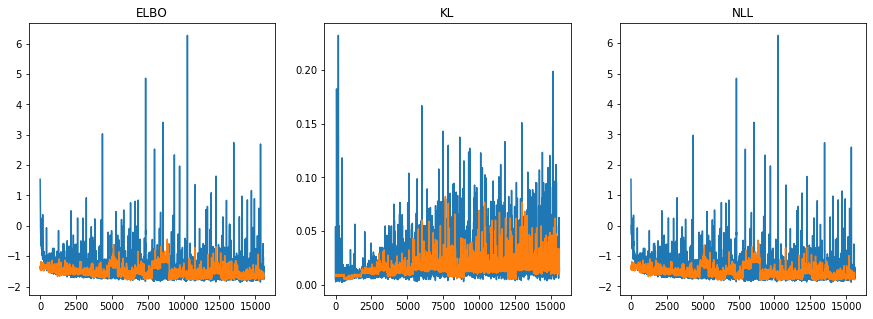

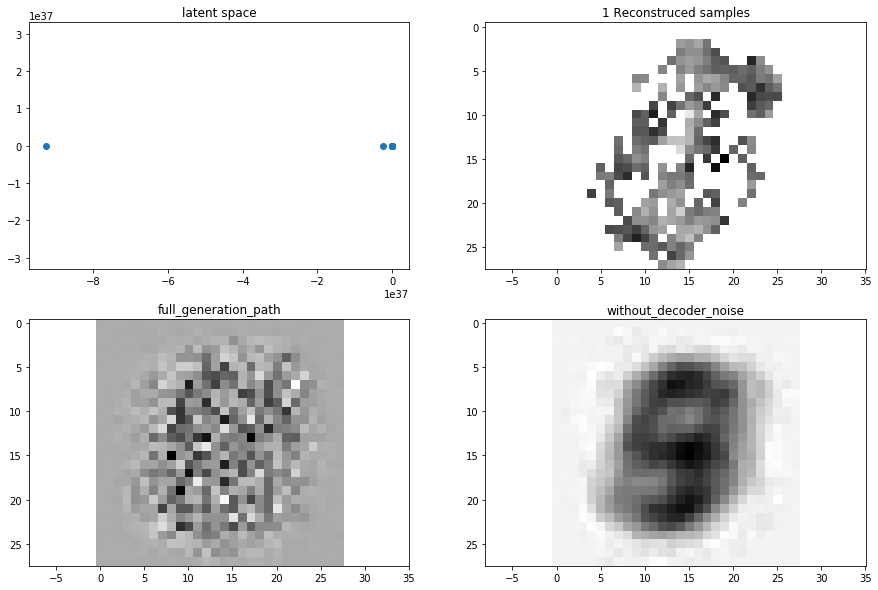

In [0]:
latent_space = latent_spaces[0]
vae = VAE(latent_space).to(device)
train_loss, train_kld, train_nll, val_loss, val_kld, val_nll = train_vae(vae)
plot_loss(train_loss, train_kld, train_nll, val_loss, val_kld, val_nll)
plot_samples(vae, plot_data, latent_space)

In [0]:
latent_space = latent_spaces[1]
vae = VAE(latent_space).to(device)
train_loss, train_kld, train_nll, val_loss, val_kld, val_nll = train_vae(vae)
plot_loss(train_loss, train_kld, train_nll, val_loss, val_kld, val_nll)
plot_samples(vae, plot_data, latent_space)

--- epoch: 0 sec: 7.471363306045532 ---
loss: -1.3015167713165283 val loss: -1.4851410388946533 KLD: 0.010028303600847721 val KLD: 0.010419879108667374 



--- epoch: 0 sec: 7.629845380783081 ---
loss: -0.8094481229782104 val loss: -0.8083714842796326 KLD: 0.009620193392038345 val KLD: 0.004381983540952206 

--- epoch: 5 sec: 7.568554401397705 ---
loss: -1.8321192264556885 val loss: -1.8082854747772217 KLD: 0.07610901445150375 val KLD: 0.047657426446676254 

--- epoch: 10 sec: 7.601228952407837 ---
loss: -1.9443364143371582 val loss: -1.979496955871582 KLD: 0.30168482661247253 val KLD: 0.24779319763183594 

--- epoch: 15 sec: 7.487200498580933 ---
loss: -2.4153549671173096 val loss: -1.9190298318862915 KLD: 0.06871284544467926 val KLD: 0.16739070415496826 

--- epoch: 20 sec: 7.521588563919067 ---
loss: -1.9906076192855835 val loss: -0.5925208926200867 KLD: 0.11297529190778732 val KLD: 0.15190480649471283 

--- epoch: 25 sec: 7.4926300048828125 ---
loss: -2.2988486289978027 val loss: -2.360137939453125 KLD: 0.11259773373603821 val KLD: 0.07106414437294006 



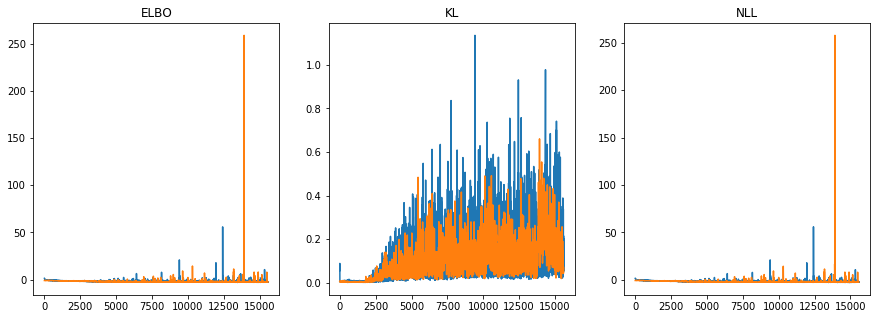

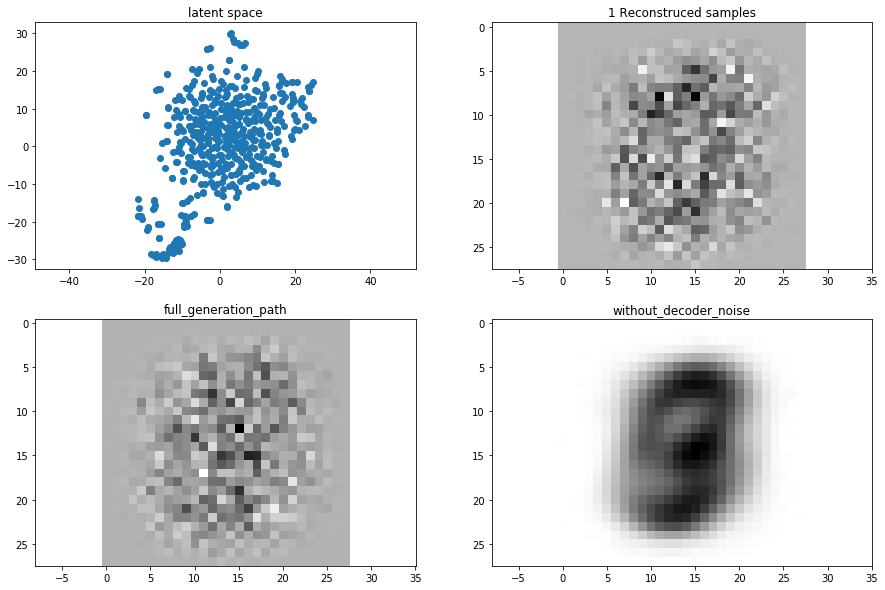

In [0]:
latent_space = latent_spaces[2]
vae = VAE(latent_space).to(device)
train_loss, train_kld, train_nll, val_loss, val_kld, val_nll = train_vae(vae)
plot_loss(train_loss, train_kld, train_nll, val_loss, val_kld, val_nll)
plot_samples(vae, plot_data, latent_space)